In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Check GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Who is she資料讀入及前處理

In [3]:
data_path = "./dataset/training_set/"
x_data_list = []
y_data_list = []
for roots, _, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])
data = pd.DataFrame({'file':x_data_list, 'class':y_data_list})
data

,file,class
0,neru/094.png,neru
1,neru/101.png,neru
2,neru/061.png,neru
3,neru/055.png,neru
4,neru/078.png,neru
...,...,...
533,risa/042.png,risa
534,risa/012.png,risa
535,risa/069.png,risa
536,risa/038.png,risa


In [4]:
submission = pd.read_csv('./dataset/sample_submission.csv')
test_path = "./dataset/testing_set/"
test_list = submission.copy()
test_list['id'] = test_list['id']+'.png'
test_list['class'] = np.nan
test_list

,id,class
0,61B0E5C347.png,NaN
1,129970B6FE.png,NaN
2,9B563E666C.png,NaN
3,730049E065.png,NaN
4,36063E5BF3.png,NaN
...,...,...
433,B7C62F06E0.png,NaN
434,88DE9A0DA4.png,NaN
435,D2C2A30BBD.png,NaN
436,FCED87FC66.png,NaN


Text(0, 0.5, '')

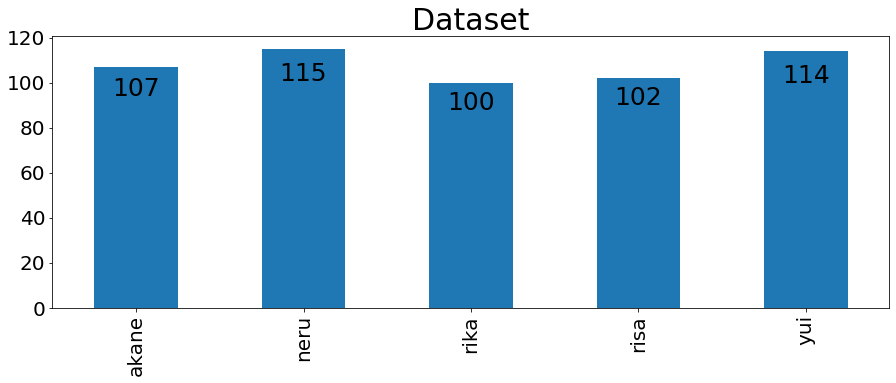

In [5]:
ax = data.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = data.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Dataset", fontsize=30)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

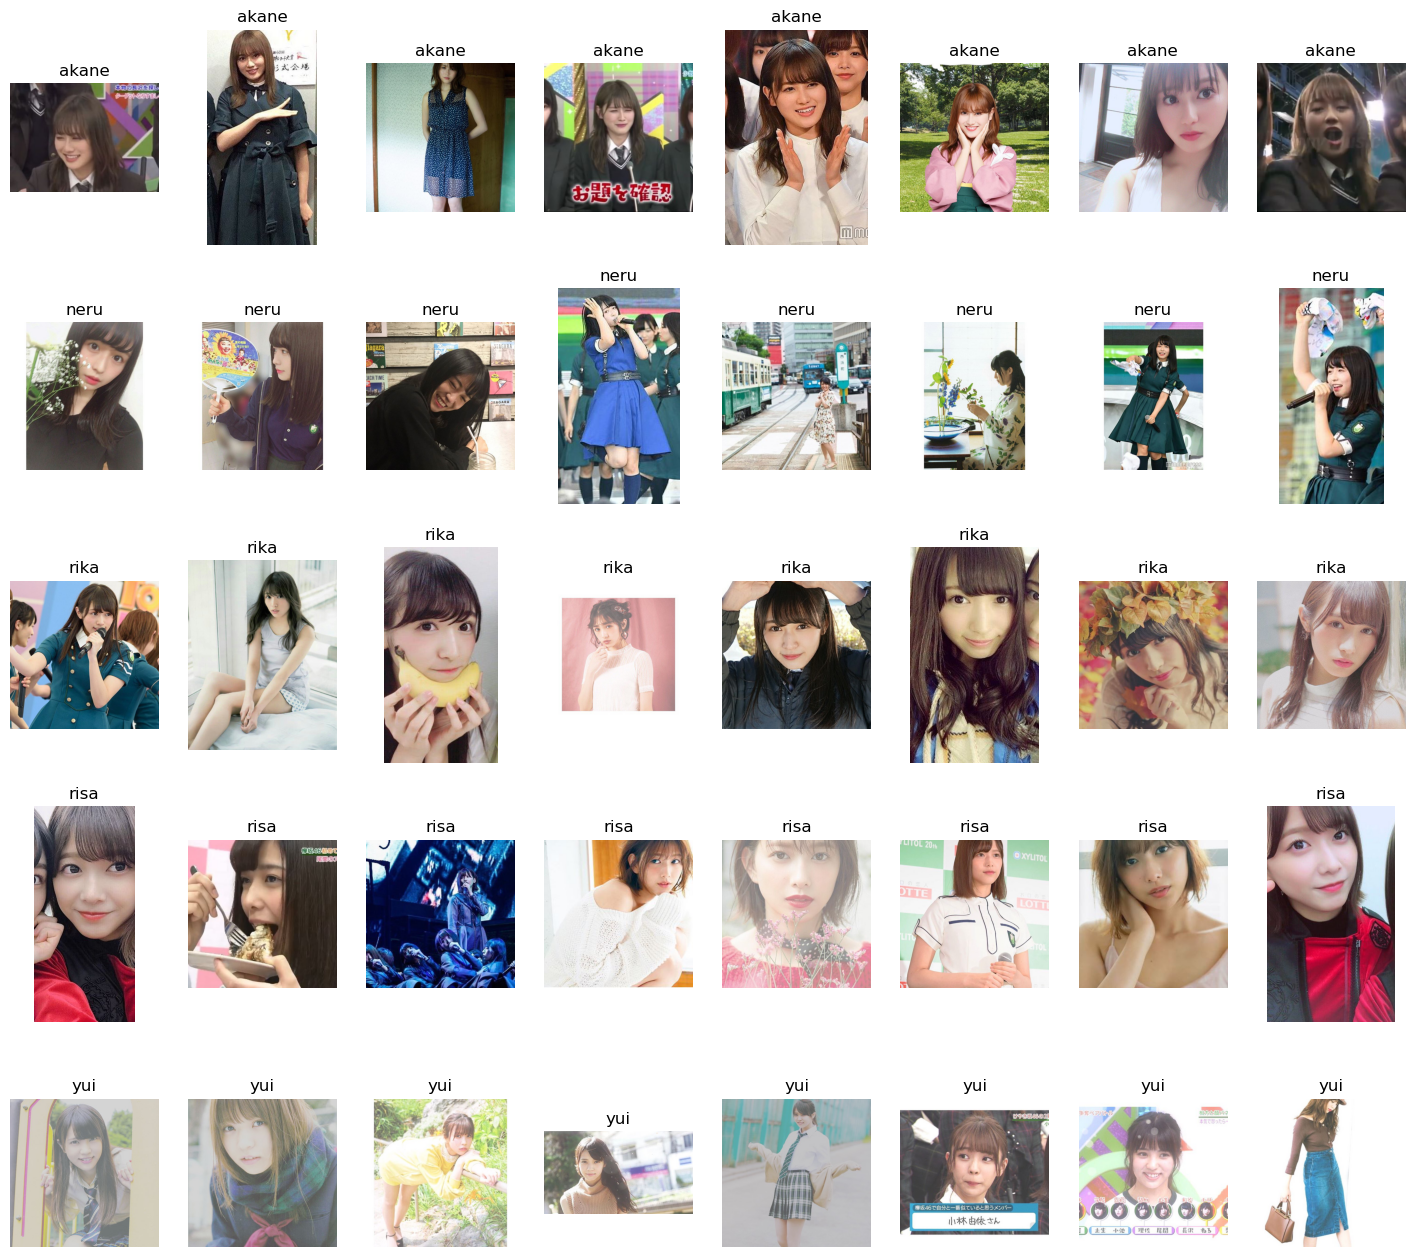

In [6]:
fig = plt.figure(figsize=(18, 20), dpi=100)
i = 1
for label, files in data.groupby('class')['file']:
    for file in files[:8]:
        img = cv2.imread(os.path.join(data_path, file), cv2.IMREAD_COLOR)[:, :, ::-1]
        plt.subplot(6, 8, i)
        plt.title(label)
        plt.imshow(img)
        plt.axis('off')
        i+=1
plt.show()

In [7]:
class_map = dict(pd.read_csv('./dataset/classmap.csv').values.astype('str'))
data['class'] = data['class'].map(class_map)
data

,file,class
0,neru/094.png,4
1,neru/101.png,4
2,neru/061.png,4
3,neru/055.png,4
4,neru/078.png,4
...,...,...
533,risa/042.png,1
534,risa/012.png,1
535,risa/069.png,1
536,risa/038.png,1


In [8]:
from sklearn.model_selection import train_test_split

train_list, val_list = train_test_split(data,
                                        test_size=0.2,
                                        random_state=2020,
                                        stratify=data['class'].values)

Text(0, 0.5, '')

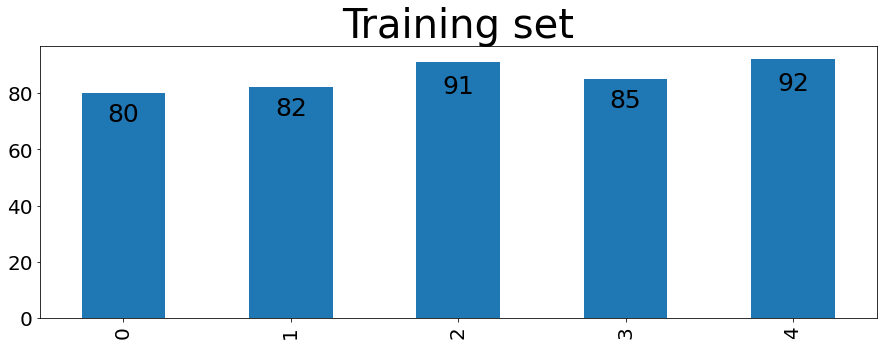

In [9]:
ax = train_list.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = train_list.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Training set", fontsize=40)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

Text(0, 0.5, '')

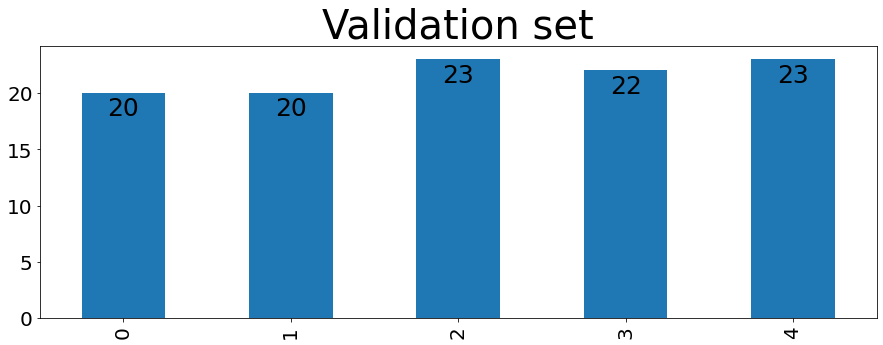

In [10]:
ax = val_list.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = val_list.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Validation set", fontsize=40)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

# Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
img_size = 224
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 50

In [13]:
train_datagen = ImageDataGenerator()
datagen = ImageDataGenerator()

In [14]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="file",
                                                    y_col="class",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = datagen.flow_from_dataframe(dataframe=val_list,
                                            directory=data_path,
                                            x_col="file",
                                            y_col="class",
                                            target_size=img_shape,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

test_generator = datagen.flow_from_dataframe(dataframe=test_list,
                                             directory=test_path,
                                             x_col="id",
                                             target_size=img_shape,
                                             batch_size=batch_size,
                                             class_mode=None,
                                             shuffle=False)

Found 430 validated image filenames belonging to 5 classes.
Found 108 validated image filenames belonging to 5 classes.
Found 438 validated image filenames.
